# Introduction

This notebook is used to simulate the Figure 2 in the paper: Karpicke, J. D., & Bauernschmidt, A. (2011). Spaced retrieval: Absolute spacing enhances learning regardless of relative spacing. Journal of Experimental Psychology: Learning, Memory, and Cognition, 37(5), 1250–1257. https://doi.org/10.1037/a0023436

The main difference between this simulation and the experiment of paper is: the interval between two trials is unclear in the experiment. Seems like the interval is shorter than 1 day. In this simulation, the unit of interval is 1 day.

Note: FSRS and SM-2 don't belong to the gradually expanding spacing schedule described in the paper. FSRS and SM-2 only expand the spacing when the recall is correct. The gradually expanding spacing schedule described in the paper expands the spacing regardless of the recall result. So the criticism of the expanding schedules is not applicable to FSRS and SM-2.

In [1]:
from fsrs_optimizer import Collection, DEFAULT_WEIGHT, power_forgetting_curve
from itertools import product
import numpy as np


def simulate(s0_factor=30, first_rating=1, test_interval=365, verbose=False):
    col = Collection(DEFAULT_WEIGHT)
    col.model.w.data[0:4] *= s0_factor
    init_stability = float(col.predict("0", f"{first_rating}")[0])

    condition = {
        "short": {
            "expand": (1, 5, 9),
            "equal": (5, 5, 5),
            "contract": (9, 5, 1),
        },
        "medium": {
            "expand": (5, 10, 15),
            "equal": (10, 10, 10),
            "contract": (15, 10, 5),
        },
        "long": {
            "expand": (15, 30, 45),
            "equal": (30, 30, 30),
            "contract": (45, 30, 15),
        },
    }

    results = []

    for absolute_spacing, groups in condition.items():
        group_results = []
        if verbose: print(f"Absolute spacing: {absolute_spacing}")
        for relative_spacing, intervals in groups.items():
            if verbose: print(f"Relative spacing: {relative_spacing}")
            proportions = []
            final_stabilities = []
            proportion_seqs = []
            recall_prob_seqs = []
            for ratings in product([1, 3], repeat=3):
                proportion = 1
                ivl_seq = [0]
                rating_seq = [first_rating]
                recall_prob_seq = []
                stability = init_stability
                stability_seq = [round(stability, 2)]
                proportion_seq = [1]
                for ivl, rating in zip(intervals, ratings):
                    ivl_seq.append(ivl)
                    rating_seq.append(rating)
                    R = power_forgetting_curve(ivl, stability)
                    recall_prob_seq.append(round(R, 2))
                    stability = float(
                        col.predict(
                            ",".join(map(str, ivl_seq)), ",".join(map(str, rating_seq))
                        )[0]
                    )
                    stability_seq.append(round(stability, 2))
                    if rating == 1:  # forget
                        proportion *= 1 - R
                    else:  # recall
                        proportion *= R
                    proportion_seq.append(proportion)
                proportions.append(proportion)
                final_stabilities.append(stability)
                recall_prob_seq.append(
                    round(power_forgetting_curve(test_interval, stability), 2)
                )
                if verbose:
                    print(
                        f"Ratings: {ratings}, proportion: {proportion:.3f}, recall_prob_seq: {recall_prob_seq}, stability_seq: {stability_seq}"
                    )
                proportion_seqs.append(proportion_seq)
                recall_prob_seqs.append(recall_prob_seq)

            retentions = sum(
                np.array(proportion_seqs)
                * np.array(recall_prob_seqs)
                / sum(np.array(proportion_seqs))
            )
            final_performance = retentions[-1]
            print(f"Intervals: {intervals + (test_interval,)}")
            print(f"Retentions: {tuple(retentions.round(4))}")
            print(f"Final performance: {final_performance * 100:.2f}%")
            group_results.append(final_performance)
        results.append(group_results)
    return results


results = simulate(verbose=True)

Absolute spacing: short
Relative spacing: expand
Ratings: (1, 1, 1), proportion: 0.000, recall_prob_seq: [0.99, 0.84, 0.6, 0.1], stability_seq: [16.84, 2.76, 1.17, 0.85]
Ratings: (1, 1, 3), proportion: 0.001, recall_prob_seq: [0.99, 0.84, 0.6, 0.21], stability_seq: [16.84, 2.76, 1.17, 4.08]
Ratings: (1, 3, 1), proportion: 0.001, recall_prob_seq: [0.99, 0.84, 0.88, 0.15], stability_seq: [16.84, 2.76, 7.48, 2.05]
Ratings: (1, 3, 3), proportion: 0.005, recall_prob_seq: [0.99, 0.84, 0.88, 0.4], stability_seq: [16.84, 2.76, 7.48, 15.97]
Ratings: (3, 1, 1), proportion: 0.007, recall_prob_seq: [0.99, 0.97, 0.76, 0.13], stability_seq: [16.84, 18.32, 2.98, 1.36]
Ratings: (3, 1, 3), proportion: 0.023, recall_prob_seq: [0.99, 0.97, 0.76, 0.34], stability_seq: [16.84, 18.32, 2.98, 10.9]
Ratings: (3, 3, 1), proportion: 0.037, recall_prob_seq: [0.99, 0.97, 0.96, 0.2], stability_seq: [16.84, 18.32, 25.68, 3.55]
Ratings: (3, 3, 3), proportion: 0.925, recall_prob_seq: [0.99, 0.97, 0.96, 0.56], stabilit

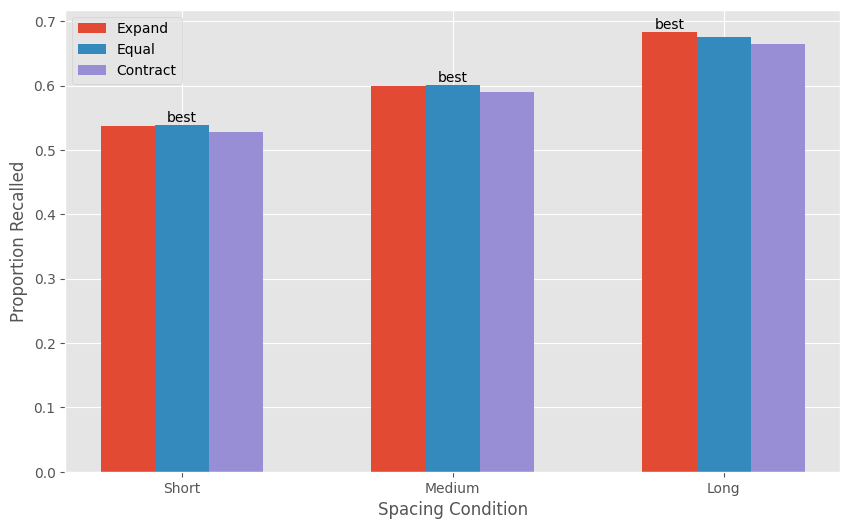

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")


def bar_chat(results, save=False):
    groups = ["Short", "Medium", "Long"]
    subgroups = ["Expand", "Equal", "Contract"]
    values = np.array(results)

    plt.figure(figsize=(10, 6))

    bar_width = 0.2

    group_pos = np.arange(len(groups))

    for i, subgroup in enumerate(subgroups):
        bars = plt.bar(group_pos + i * bar_width, values[:, i], width=bar_width, label=subgroup)
        
        # 为每个主组中的最大值添加标记
        for j, bar in enumerate(bars):
            if values[j, i] == max(values[j]):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'best', 
                        ha='center', va='bottom')
    plt.legend()
    plt.xticks(group_pos + bar_width, groups)
    plt.xlabel("Spacing Condition")
    plt.ylabel("Proportion Recalled")
    if save:
        plt.savefig("simulated.jpg")
    plt.show()


bar_chat(results, True)

The original figure 2 in the paper:

![img](original.jpg)

It makes nonsense to compare the relative spacing schedules without taking into account the recall result. Because the recall result has a great impact on the spacing effect. Here I modify some parameters and get a very different bar chart.

Intervals: (1, 5, 9, 7)
Retentions: (0.74, 0.6926, 0.7533, 0.8462)
Final performance: 84.62%
Intervals: (5, 5, 5, 7)
Retentions: (0.44, 0.6534, 0.7774, 0.8086)
Final performance: 80.86%
Intervals: (9, 5, 1, 7)
Retentions: (0.34, 0.6373, 0.9112, 0.7752)
Final performance: 77.52%
Intervals: (5, 10, 15, 7)
Retentions: (0.44, 0.5565, 0.6387, 0.7981)
Final performance: 79.81%
Intervals: (10, 10, 10, 7)
Retentions: (0.33, 0.5269, 0.6682, 0.7885)
Final performance: 78.85%
Intervals: (15, 10, 5, 7)
Retentions: (0.27, 0.5105, 0.7433, 0.7837)
Final performance: 78.37%
Intervals: (15, 30, 45, 7)
Retentions: (0.27, 0.3578, 0.4374, 0.7611)
Final performance: 76.11%
Intervals: (30, 30, 30, 7)
Retentions: (0.2, 0.336, 0.4676, 0.758)
Final performance: 75.80%
Intervals: (45, 30, 15, 7)
Retentions: (0.16, 0.3289, 0.5567, 0.7575)
Final performance: 75.75%


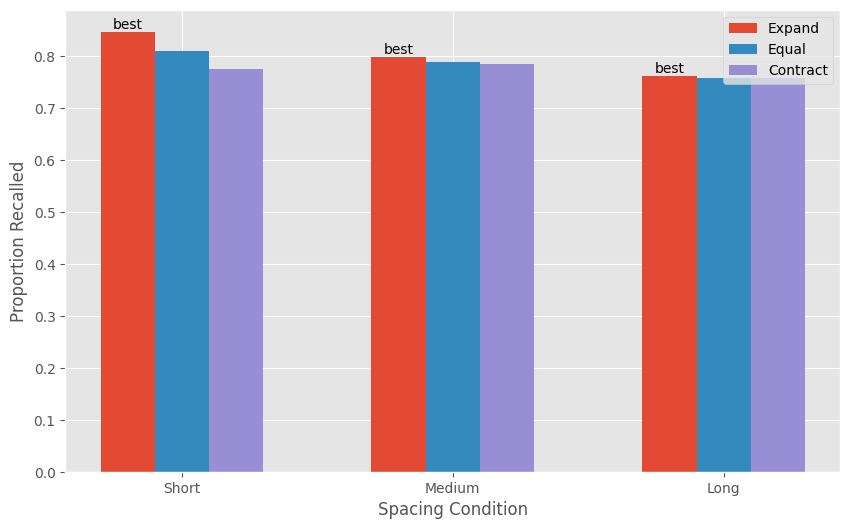

In [3]:
results = simulate(s0_factor=0.5,first_rating=1, test_interval=7)
bar_chat(results)

Intervals: (1, 5, 9, 7)
Retentions: (1.0, 0.9899, 0.9893, 0.9889)
Final performance: 98.89%
Intervals: (5, 5, 5, 7)
Retentions: (0.99, 0.9996, 0.9993, 0.9891)
Final performance: 98.91%
Intervals: (9, 5, 1, 7)
Retentions: (0.99, 0.9992, 0.9998, 0.9892)
Final performance: 98.92%
Intervals: (5, 10, 15, 7)
Retentions: (0.99, 0.9893, 0.9877, 0.9881)
Final performance: 98.81%
Intervals: (10, 10, 10, 7)
Retentions: (0.99, 0.9886, 0.9881, 0.9885)
Final performance: 98.85%
Intervals: (15, 10, 5, 7)
Retentions: (0.98, 0.9879, 0.9987, 0.9887)
Final performance: 98.87%
Intervals: (15, 30, 45, 7)
Retentions: (0.98, 0.9657, 0.9585, 0.9947)
Final performance: 99.47%
Intervals: (30, 30, 30, 7)
Retentions: (0.97, 0.9713, 0.9694, 0.9955)
Final performance: 99.55%
Intervals: (45, 30, 15, 7)
Retentions: (0.95, 0.9672, 0.9818, 0.9961)
Final performance: 99.61%


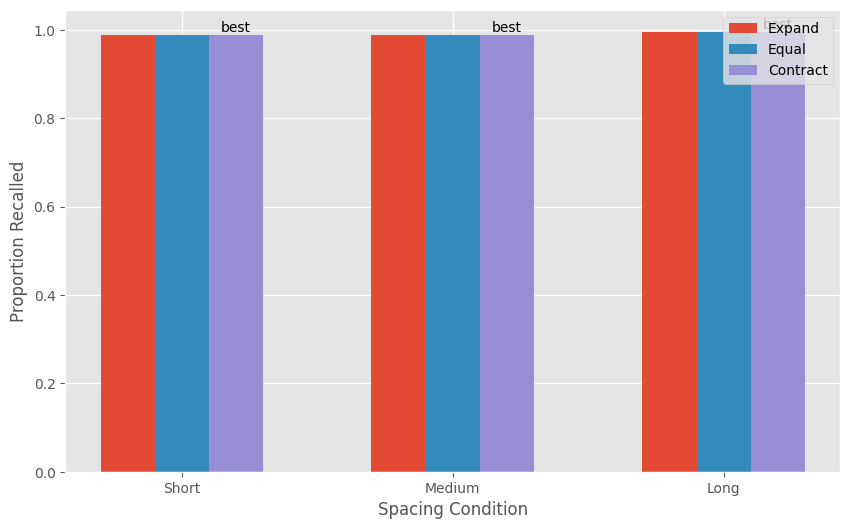

In [4]:
results = simulate(first_rating=3, test_interval=7)
bar_chat(results)